In [1]:
!pip install opencv-python numpy networkx


Defaulting to user installation because normal site-packages is not writeable


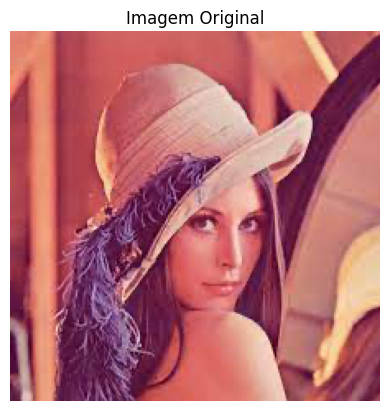

Áreas segmentadas (cores média): [(101.22279792746114, 86.279792746114, 152.56476683937825), (101.22419928825622, 92.288256227758, 163.24555160142347)]
Conjunto Independente: {0, 1}


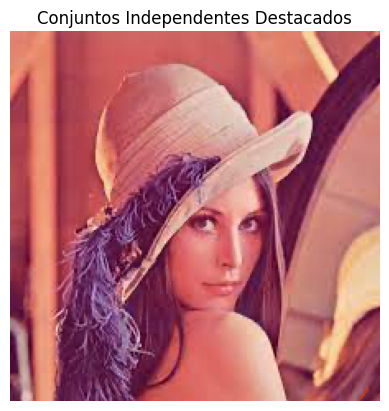

In [4]:
import cv2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

def segment_image(image_path):
    """
    Realiza a segmentação da imagem e retorna as áreas segmentadas.
    
    :param image_path: Caminho da imagem a ser segmentada.
    :return: Lista de áreas segmentadas.
    """
    # Carregar a imagem
    image = cv2.imread(image_path)
    
    # Mostrar a imagem original
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Imagem Original")
    plt.axis("off")
    plt.show()
    
    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar um filtro Gaussiano para suavizar a imagem
    blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)
    
    # Aplicar a técnica de Canny para detectar bordas
    edges = cv2.Canny(blurred_image, 100, 100)

    # Encontrar contornos
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extrair características das áreas segmentadas
    segmented_areas = []
    for contour in contours:
        if cv2.contourArea(contour) > 50:  # Ajustar limite de área
            mask = np.zeros(gray_image.shape, dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_val = cv2.mean(image, mask=mask)  # Calcular a média das cores na máscara
            segmented_areas.append(mean_val[:3])  # Adicionar as cores (B, G, R)
            
#    contour_image = image.copy()
#    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Desenha contornos em verde
#    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
#    plt.title("Contornos Detectados")
#    plt.axis("off")
#    plt.show()
    
    return segmented_areas, contours, image

def create_similarity_graph(data_points, similarity_threshold):
    """
    Cria um grafo de similaridade baseado nos dados fornecidos.
    
    :param data_points: Lista de características de áreas segmentadas.
    :param similarity_threshold: Limite para considerar dois pontos como similares.
    :return: Grafo de similaridade.
    """
    graph = nx.Graph()
    
    # Adiciona nós ao grafo
    for i in range(len(data_points)):
        graph.add_node(i, features=data_points[i])
    
    # Adiciona arestas com base na similaridade
    for i in range(len(data_points)):
        for j in range(i + 1, len(data_points)):
            similarity = calculate_similarity(data_points[i], data_points[j])
            if similarity > similarity_threshold:
                graph.add_edge(i, j)

    return graph

def calculate_similarity(features1, features2):
    """
    Calcula a similaridade entre dois conjuntos de características.
    
    :param features1: Características do primeiro ponto.
    :param features2: Características do segundo ponto.
    :return: Similaridade entre os dois pontos.
    """
    return 1 / (1 + np.linalg.norm(np.array(features1) - np.array(features2)))  # Distância euclidiana

def greedy_independent_set(graph):
    """
    Encontra um conjunto independente usando o método guloso.
    
    :param graph: Grafo de similaridade.
    :return: Conjunto independente encontrado.
    """
    independent_set = set()
    nodes = set(graph.nodes())
    
    while nodes:
        # Escolhe um nó aleatório
        node = random.choice(list(nodes))
        independent_set.add(node)
        
        # Remove o nó e seus vizinhos do conjunto de nós
        nodes.remove(node)
        nodes -= set(graph.neighbors(node))
        
    return independent_set

def visualize_independent_set(image, contours, independent_set):
    """
    Visualiza o conjunto independente destacando cada contorno com uma cor diferente.
    
    :param image: Imagem original.
    :param contours: Contornos da imagem.
    :param independent_set: Conjunto independente de índices de contornos.
    """
    # Criar uma cópia da imagem para desenhar os contornos
    result_image = image.copy()
    
    # Gera uma cor aleatória para cada área do conjunto independente
    for idx in independent_set:
        color = tuple([random.randint(0, 255) for _ in range(3)])
        cv2.drawContours(result_image, [contours[idx]], -1, color, -1)  # Preenche contorno com cor

    # Exibe a imagem com os conjuntos independentes em cores distintas
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Conjuntos Independentes Destacados")
    plt.axis("off")
    plt.show()

# Exemplo de uso
if __name__ == "__main__":
    # Caminho para a imagem
    image_path = "lena.png"

    # Realiza a segmentação da imagem
    segmented_areas, contours, original_image = segment_image(image_path)
    print("Áreas segmentadas (cores média):", segmented_areas)

    # Cria o grafo de similaridade
    if segmented_areas:
        similarity_threshold = 50  # Defina um limite de similaridade
        graph = create_similarity_graph(segmented_areas, similarity_threshold)

        # Encontra o conjunto independente
        independent_set = greedy_independent_set(graph)
        print("Conjunto Independente:", independent_set)

        # Visualiza os contornos do conjunto independente com cores diferentes
        visualize_independent_set(original_image, contours, independent_set)
    else:
        print("Nenhuma área segmentada foi encontrada.")
